In [1]:
import numpy as np
from sdm.config import get_db_connection
from sdm.crud_embeddings import get_all_embeddings
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

## Get data from postgres

In [2]:
with get_db_connection(db_type="postgres") as db:
    df = get_all_embeddings(db)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36780 entries, 0 to 36779
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         36780 non-null  int64 
 1   text       36780 non-null  object
 2   doc_type   36780 non-null  object
 3   doc_id     36780 non-null  object
 4   embedding  36780 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [3]:
X = df["embedding"].tolist()

In [6]:
scores = []

# elbow method like in data mining
# for n_cluster in range(2, 60, 3):
# for n_cluster in range(2, 12):
for n_cluster in range(10, 400, 20):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X)
    label = kmeans.labels_
    db_score = davies_bouldin_score(X, label)
    sil_score = silhouette_score(X, label)
    scores.append({
        "K": n_cluster,
        "inertia": kmeans.inertia_,
        "db": db_score,
        "silh": sil_score,
        })

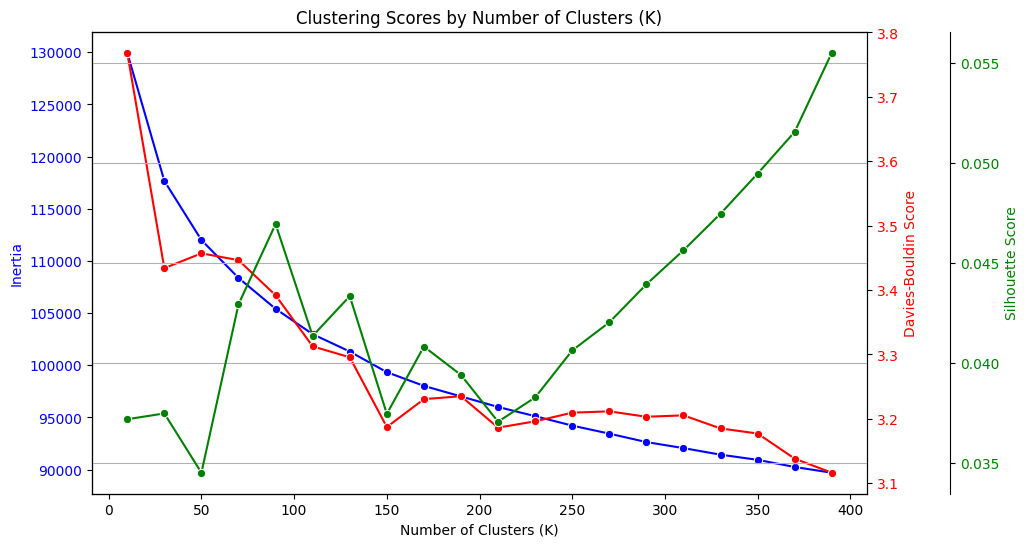

In [7]:
df_scores = pd.DataFrame(scores)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia
sns.lineplot(data=df_scores, x="K", y="inertia", ax=ax1, color="blue", marker="o")
ax1.set_ylabel("Inertia", color="blue")
ax1.set_xlabel("Number of Clusters (K)")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for the Davies-Bouldin score
ax2 = ax1.twinx()
sns.lineplot(data=df_scores, x="K", y="db", ax=ax2, color="red", marker="o")
ax2.set_ylabel("Davies-Bouldin Score", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Create a third y-axis for the Silhouette score
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis to avoid overlap
sns.lineplot(data=df_scores, x="K", y="silh", ax=ax3, color="green", marker="o")
ax3.set_ylabel("Silhouette Score", color="green")
ax3.tick_params(axis='y', labelcolor="green")

plt.title('Clustering Scores by Number of Clusters (K)')
plt.grid(True)
plt.show()

In [4]:
K = 95
kmeans = KMeans(n_clusters=K, random_state=42).fit(X)
labels = kmeans.labels_

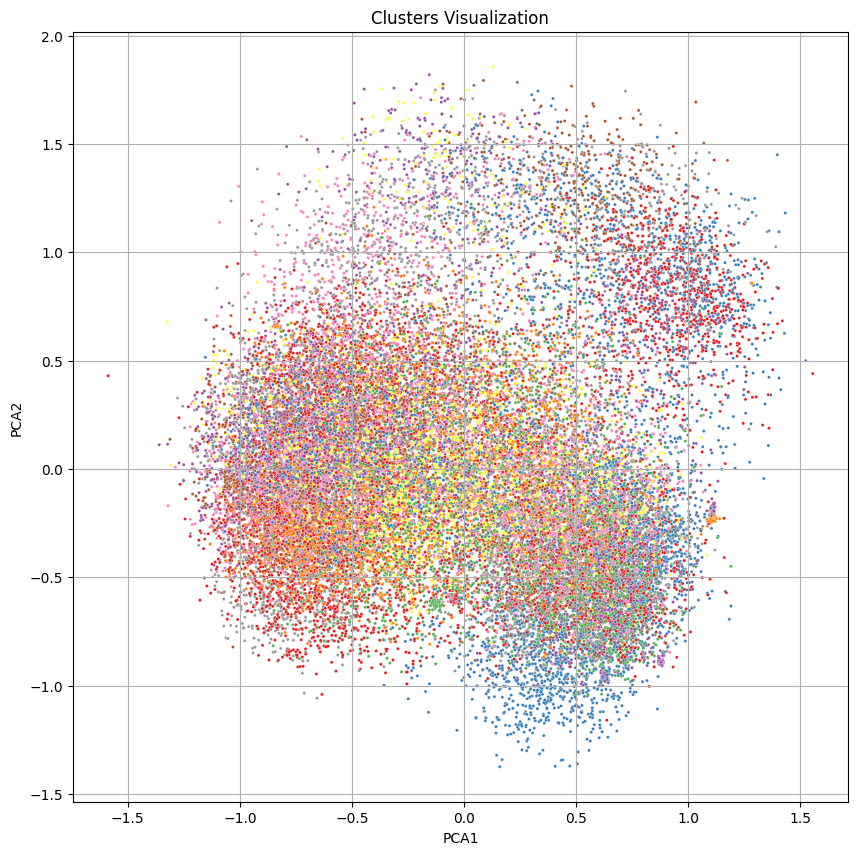

In [5]:
df["labels"] = labels
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(df["embedding"].tolist())

# Add reduced components to the dataframe for plotting
df['PCA1'] = X_reduced[:, 0]
df['PCA2'] = X_reduced[:, 1]

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PCA1', y='PCA2', hue='labels', palette='Set1', data=df, s=5, legend=False)
plt.title('Clusters Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

In [6]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(np.array(df["embedding"].tolist())) # tsne does not like list of lists :/

df['TSNE1'] = X_reduced[:, 0]
df['TSNE2'] = X_reduced[:, 1]

## Plot Clusters

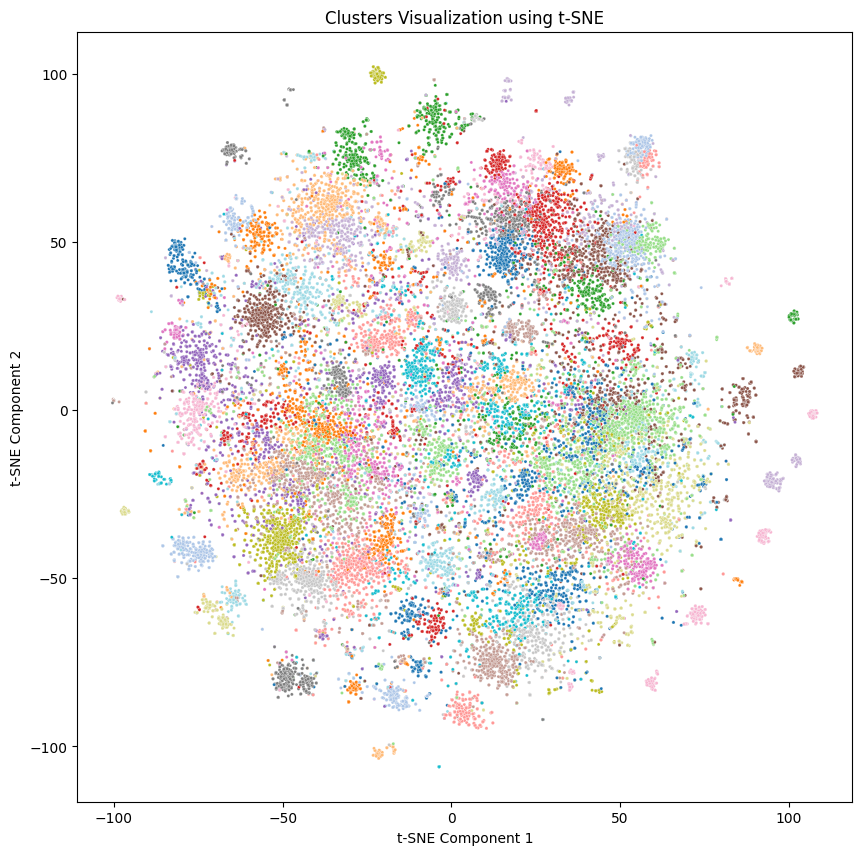

In [7]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='labels', palette='tab20', data=df, s=5, legend=False)

plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Compare by platform/doctype

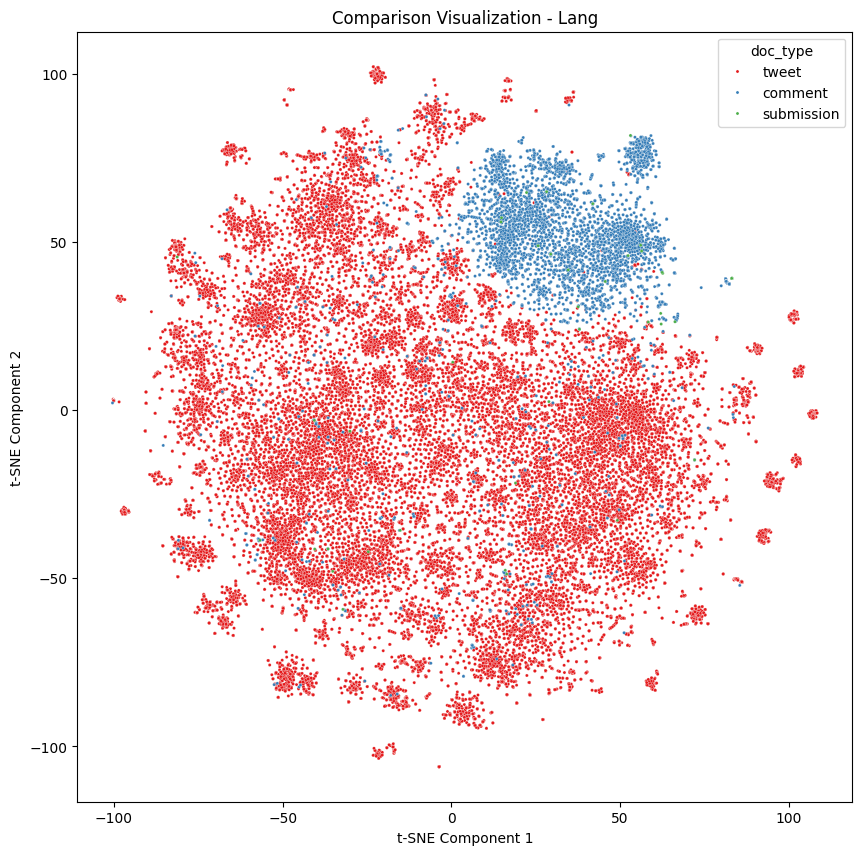

In [20]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='doc_type',
                     palette="Set1",
                     data=df, s=5, legend=True)

plt.title('Comparison Visualization - Lang')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

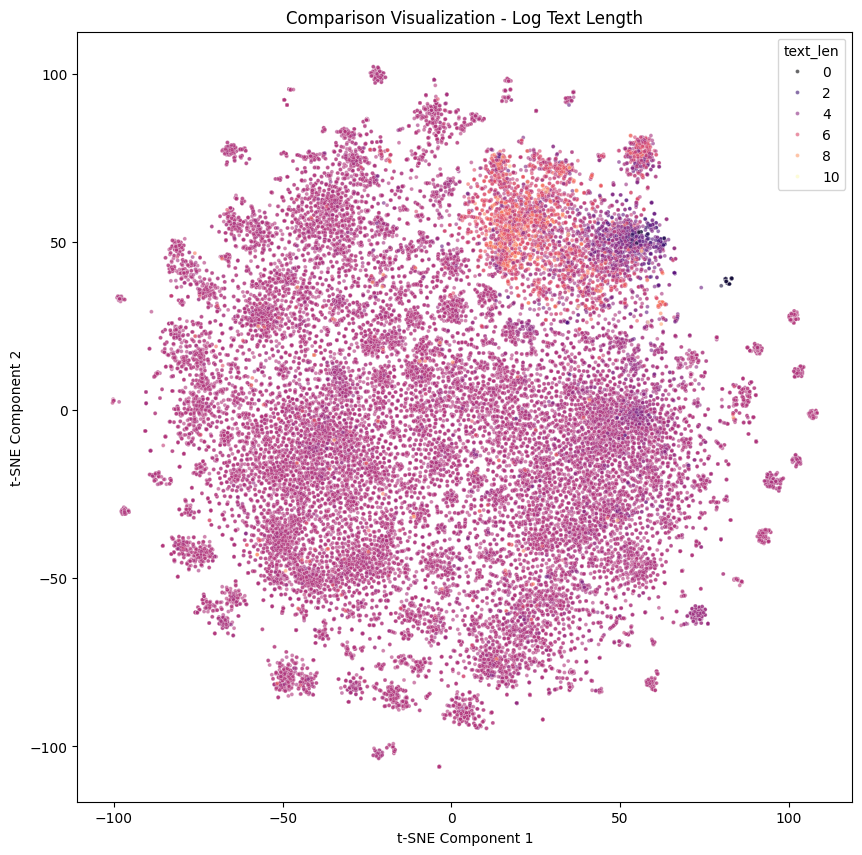

In [21]:
df["text_len"] = df["text"].apply(lambda x: np.log(len(x)))
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="TSNE1", y="TSNE2", hue="text_len",
                     palette="magma",
                     data=df, s=8, alpha=0.6, legend=True)

plt.title("Comparison Visualization - Log Text Length")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## Intruder detection

In [66]:
# TODO add to lib
def intruder_detection(df, num_samples=3):
    cluster = df['labels'].sample(n=1).values[0]
    same_cluster_samples = df[df['labels'] == cluster].sample(n=2, random_state=42)
    different_cluster_samples = df[df['labels'] != cluster].sample(n=1, random_state=42)
    intruder_group = pd.concat([same_cluster_samples, different_cluster_samples])
    for _, row in intruder_group.sample(frac=1).iterrows():
        print(f"Text from Cluster {row['labels']}, Platform: {row['doc_type']}")
        print(f"{row['text']}\n{'-'*50}")

intruder_detection(df)

Text from Cluster 34, Platform: comment
I was responsible for a national organization that provides the means for many to post here in Reddit, as did thousands of employees who worked in my organization.

Even though people hate energy companies, they are drivers of our economy and way of life, without them we'd be living a far less comfortable lifestyle.

There are millions of examples that i could give of people who are working to maintain our standards of living, but who aren't appreciated.

Climate scientists flying to France are just another example of people doing their work.  Given they are preaching a "carbon" efficient lifestyle, I'd expect them to set the example.  They aren't IMO.
--------------------------------------------------
Text from Cluster 34, Platform: comment
Another Question I have deals with President Obama's "Mission Innovation" initiative wherein 19-20 countries are committing to double their respective clean energy R&D investment over the next 5 years. Was th

In [10]:
df.groupby("labels")["id"].count().describe()

count      95.000000
mean      387.157895
std       204.832589
min        69.000000
25%       219.500000
50%       365.000000
75%       547.000000
max      1096.000000
Name: id, dtype: float64

Topic 87 with K=95, random state 42: _Polar bears_ (love this one)

In [22]:
for _, x in df[df["labels"] == 87].iterrows():
    print("--"*20)
    print(x["text"])

----------------------------------------
Polar bears are scientists more than anything else??
----------------------------------------
The coolest thing about polar bears is that they were able to exploit the sea ice at all! Imagine rolling up on an area of snow and ice as far as the eye can see. To the uninitiated, the Arctic looks like something from another planet, but polar bears, along with Arctic Peoples, managed to see the potential and learned how to survive.
----------------------------------------
Polar bears have evolved over about 350,000 years to become highly specialized predators of ice seals. In most of the Arctic, they rarely came to land and prefer to remain out on the floating sea ice- which is why they are considered a marine mammal in the US and elsewhere. While polar bears stranded onshore will sometimes eat terrestrial foods- they are obligate carnivores and the latest research into their physiology and energetic requirements conclude that terrestrial foods are i

In [ ]:
valid_clusters = df[df["doc_type"].isin(["submission", "comment"])]["labels"].unique()
df_reddit_clusters = df[df["labels"].isin(valid_clusters)]
df_reddit_clusters

,id,text,doc_type,doc_id,embedding,labels,PCA1,PCA2,TSNE1,TSNE2
0,5321,$1 trillion funding gap for poorest countries’...,tweet,671780808412254210,"[-0.13590758, 0.17315766, -0.008780155, 0.1163...",33,-1.033590,0.279754,-75.391678,-6.464790
1,5322,$3.4 Trillion: #Fossil ]Fuel Divestment Commit...,tweet,672364415400828932,"[0.00019094069, 0.17916173, -0.0056449766, 0.0...",21,-0.587734,0.507200,-63.630978,62.903133
2,5323,$3.4 Trillion: #Fossil ]Fuel Divestment Commit...,tweet,672449986647330816,"[-0.00010863412, 0.18258078, -0.005554083, 0.0...",21,-0.552205,0.538330,-63.627102,62.901608
4,5325,$#COP21: Suivons les négociations et nous verr...,tweet,673645638286835712,"[-0.041687813, 0.22417882, -0.011368999, -0.05...",72,0.260215,-0.568708,52.839203,-46.609215
5,5326,£352bn investors’ coalition launched to push f...,tweet,674603800607531008,"[-0.13008502, 0.04327183, -0.0046115965, -0.02...",63,-0.593449,0.389870,-50.071022,59.312828
...,...,...,...,...,...,...,...,...,...,...
36775,5316,NaN,submission,chljre,"[-0.072524086, 0.011674279, -0.015378429, 0.14...",13,1.284732,0.856759,83.041084,39.141365
36776,5317,NaN,submission,6rjxlu,"[-0.072524086, 0.011674279, -0.015378429, 0.14...",13,1.284732,0.856759,83.041084,39.141365
36777,5318,NaN,submission,3h8p5k,"[-0.072524086, 0.011674279, -0.015378429, 0.14...",13,1.284732,0.856759,83.041084,39.141365
36778,5319,NaN,submission,3wss8n,"[-0.072524086, 0.011674279, -0.015378429, 0.14...",13,1.284732,0.856759,83.041084,39.141365


In [17]:
counts = df.groupby(["labels", "doc_type"]).size().reset_index(name="count")
counts["proportion"] = counts.groupby("labels")["count"].transform(lambda x: x / x.sum())
counts

,labels,doc_type,count,proportion
0,0,comment,5,0.008039
1,0,tweet,617,0.991961
2,1,comment,484,0.968000
3,1,submission,2,0.004000
4,1,tweet,14,0.028000
...,...,...,...,...
190,92,comment,35,0.201149
191,92,submission,1,0.005747
192,92,tweet,138,0.793103
193,93,tweet,298,1.000000
